In [13]:
import sys
from os import path
sys.path.append(path.join(path.dirname(path.abspath("__file__")), '..'))

import matplotlib.pyplot as pl

import config as ac
q = 1.602176e-19 #C
meV2J=1e-3*q #meV to Joules

# Input File(s)
# -------------
ac.inputfilename = "sample-qw-barrierdope"

ac.use_cython = True #provides a speed up for aestimo and aestimo_numpy
# Shooting method parameters for Schrödinger Equation solution
ac.delta_E = 0.5*meV2J #Energy step (Joules) for initial search. Initial delta_E is 1 meV. 
ac.d_E = 1e-5*meV2J #Energy step (Joules) within Newton-Raphson method when improving the precision of the energy of a found level.
ac.E_start = 0.0    #Energy to start shooting method from (if E_start = 0.0 uses minimum of energy of bandstructure)
ac.Estate_convergence_test = 1e-9*meV2J
# FermiDirac
ac.FD_d_E = 1e-9 #Initial and minimum Energy step (meV) for derivative calculation for Newton-Raphson method to find E_F
ac.FD_convergence_test = 1e-6 #meV
ac.np_d_E = 1.0 # Energy step (meV) for dispersion calculations
# Poisson Loop
ac.damping = 0.5    #averaging factor between iterations to smooth convergence.
ac.max_iterations=80 #maximum number of iterations.
ac.convergence_test=1e-6 #convergence is reached when the ground state energy (meV) is stable to within this number between iterations.

# Aestimo_numpy_h
ac.strain = True # for aestimo_numpy_h
ac.piezo=True
#Set material type used in the structure 
ac.Wurtzite=True
ac.Zincblind=False

# Output Files
# ------------

notebook_name = "match_to_ISB_textbook_fig23"
# filename_without_extension = path.splitext(path.basename("tutoria1_sef_consistent_debugging.ipynb"))[0]

ac.output_directory = notebook_name
ac.parameters = True
ac.electricfield_out = True
ac.potential_out = True
ac.sigma_out = True
ac.probability_out = True
ac.states_out = True

# Result Viewer
# -------------
ac.resultviewer = True
ac.wavefunction_scalefactor = 200 # scales wavefunctions when plotting QW diagrams
# Messages
# --------
ac.messagesoff = False
ac.logfile = 'aestimo.log'

#Here, we will alter the default settings of the config.py file for the purposes of this tutorial
ac.use_cython = False
ac.messagesoff = True

import database as adatabase
from pprint import pprint

pprint(adatabase.materialproperty['GaAs'])
     

{'AVb_E': -6.92,
 'Ac': -7.17,
 'Av': 1.16,
 'B': -1.7,
 'BETAN': 2.0,
 'BETAP': 1.0,
 'Band_offset': 0.65,
 'C11': 11.879,
 'C12': 5.376,
 'Cn0': 2.8e-31,
 'Cp0': 2.8e-32,
 'Eg': 1.4223,
 'Ep': 28.8,
 'F': -1.94,
 'GA1': 6.8,
 'GA2': 1.9,
 'GA3': 2.73,
 'TAUN0': 1e-08,
 'TAUP0': 1e-08,
 'VSATN': 300000.0,
 'VSATP': 600000.0,
 'a0': 5.6533,
 'delta': 0.28,
 'epsilonStatic': 12.9,
 'm_e': 0.067,
 'm_e_alpha': 5.3782e+18,
 'm_hh': 0.45,
 'm_lh': 0.087,
 'mun0': 0.1,
 'mup0': 0.02}


In [14]:
class Structure(object): pass
s = Structure() # this will be our datastructure

# TEMPERATURE
s.T = 3.0 #Kelvin

# COMPUTATIONAL SCHEME
# 0: Schrodinger
# 1: Schrodinger + nonparabolicity
# 2: Schrodinger-Poisson
# 3: Schrodinger-Poisson with nonparabolicity
# 4: Schrodinger-Exchange interaction
# 5: Schrodinger-Poisson + Exchange interaction
# 6: Schrodinger-Poisson + Exchange interaction with nonparabolicity
s.computation_scheme =0

# Non-parabolic effective mass function
# 0: no energy dependence
# 1: Nelson's effective 2-band model
# 2: k.p model from Vurgaftman's 2001 paper
s.meff_method = 0

# Non-parabolic Dispersion Calculations for Fermi-Dirac
s.fermi_np_scheme = True #needed only for aestimo_numpy2.py

# QUANTUM
# Total subband number to be calculated for electrons
s.subnumber_e = 2
# Total subband number to be calculated for electrons (needed only for aestimo_numpy_h)
s.subnumber_h = 1 

# APPLIED ELECTRIC FIELD
s.Fapplied = 0.00/50e-9 # (V/m)

# --------------------------------
# REGIONAL SETTINGS FOR SIMULATION
# --------------------------------

# GRID
# For 1D, z-axis is choosen
s.gridfactor = 0.01 #nm
s.maxgridpoints = 200000 #for controlling the size

# REGIONS
# Region input is a two-dimensional list input.
# An example:
#         | Thickness (nm) | Material | Alloy fraction | Doping(cm^-3) | n or p type |
# Layer 0 |      250.0     |   Si     |      0         |     1e16      |     n       |
# Layer 1 |      250.0     |   Si     |      0         |     1e16      |     p       |
#
dopant = 5e18 #cm^-3, doping concentration
x_frac = 0.3
s.material =[[ 1.0, 'AlGaAs', x_frac, dopant, 'n'],
            [ 4.0, 'AlGaAs', x_frac, 0.0, 'n'],
            [ 8.0, 'GaAs', 0, 0, 'n'],
            [ 4.0, 'AlGaAs', x_frac, 0.0, 'n'],
            [ 1.0, 'AlGaAs', x_frac, dopant, 'n']]

In [15]:
def plot_QW_view(result,title):
    fig2 = pl.figure()
    pl.suptitle(title)
    pl.subplot(1, 1, 1)
    pl.plot(result.xaxis*1e9, result.fitot/meV2J, "k",label="Potential")
    for level, state in zip(result.E_state, result.wfe):
        pl.axhline(level, 0.1, 0.9, color="g", ls="--")
        pl.plot(result.xaxis*1e9, state * ac.wavefunction_scalefactor + level, "b")
        # pl.plot(xaxis, state**2*1e-9/dx*200.0+level,'b')
    pl.axhline(result.E_F, 0.1, 0.9, color="r", ls="--",label="chemical potential")
    pl.xlabel("Position (nm)")
    pl.ylabel("Energy (meV)")
    pl.grid(True)
    pl.legend()
    return fig2

INFO Total layer number: 5
INFO Total number of materials in database: 25
INFO calculation time  0.125198 s


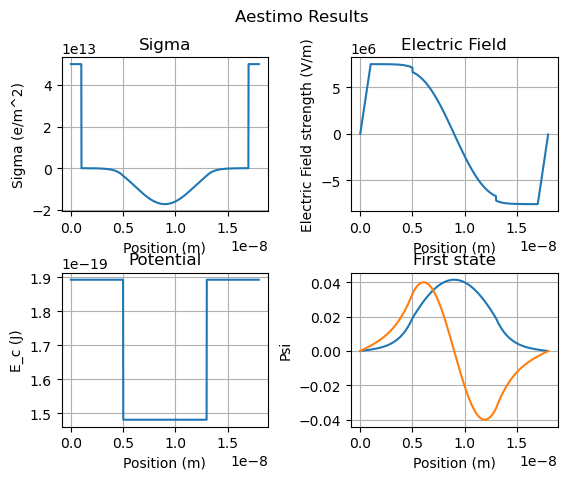

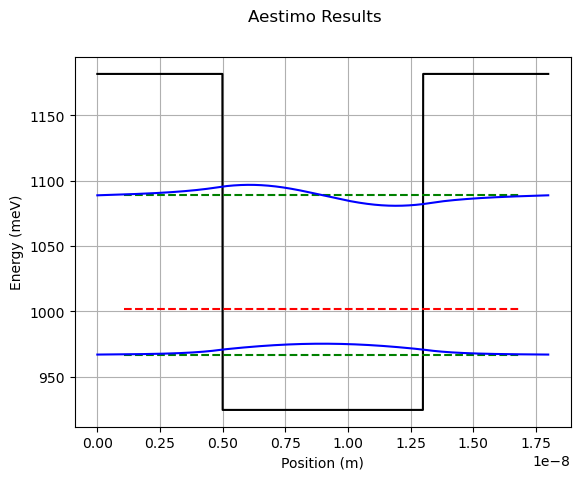

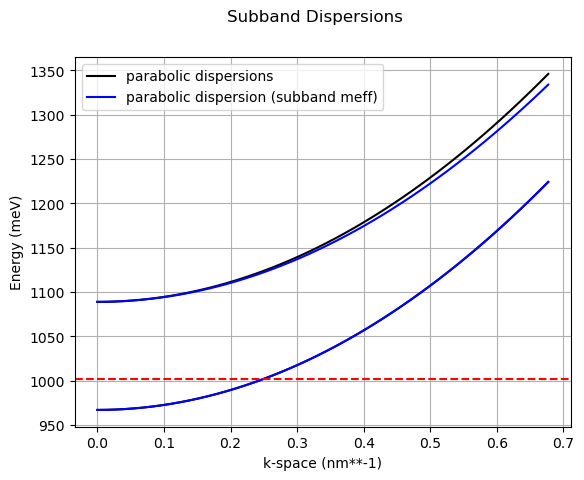

INFO Simulation is finished.


state, Energy, Population, effective mass
     ,meV    , cm**-1    , m_e**-1
    0  966.86       1e+16, 6.19e-32
    1 1088.74           0, 6.49e-32
state, Energy offset from GaAs CBM
     ,meV  
    0 42.3651
    1 164.246


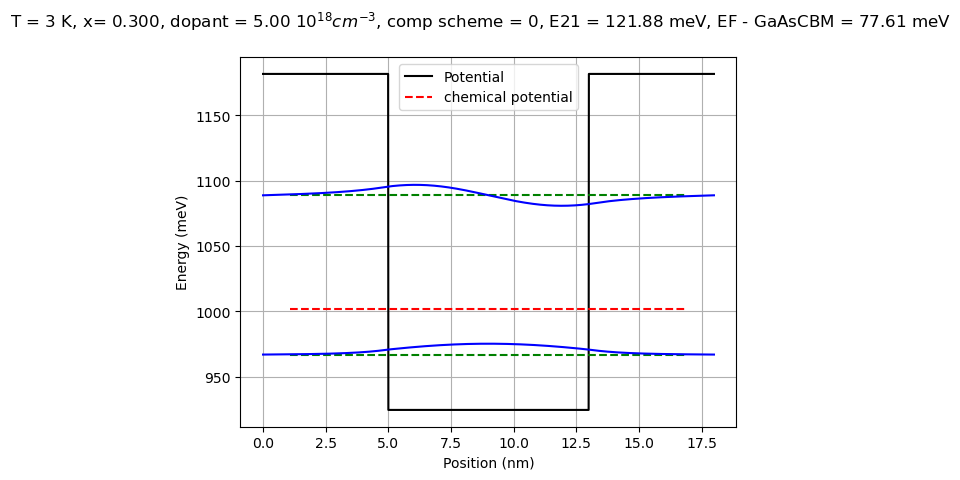

In [16]:
import aestimo as solver
# Initialise structure class
structure = s
model = solver.StructureFrom(structure,adatabase) # structure could also be a dictionary.
    
#calculate QW states
result = solver.Poisson_Schrodinger(model)



# Write the simulation results in files
%matplotlib inline
solver.save_and_plot(result,model)
solver.logger.info("Simulation is finished.")

import numpy as np
pot_GaAs = np.min(result.fitot)/meV2J  # GaAs CBM
pot_AlGaAs = np.max(result.fitot)/meV2J  # AlGaAs CBM

print('state, Energy, Population, effective mass')
print('     ,meV    , cm**-1    , m_e**-1')
for num,E,N,meff in zip(range(result.subnumber_e),result.E_state,result.N_state,result.meff_state):
    print('%5d %7g %11.3g, %7.3g' %(num,E,N,meff))

print('state, Energy offset from GaAs CBM')
print('     ,meV  ')
for num,E in zip(range(result.subnumber_e),result.E_state):
    print('%5d %7g' %(num,E-pot_GaAs))

E21 = result.E_state[1] - result.E_state[0]  # E21 is the energy difference between the first two states
EFCBM = result.E_F - pot_GaAs  # Fermi level with respect to GaAs CBM

fig_titled = plot_QW_view(result, r"T = %g K, x= %0.3f, dopant = %0.2f $10^{18} cm^{-3}$, comp scheme = %g, E21 = %0.2f meV, EF - GaAsCBM = %0.2f meV" % (s.T,x_frac,dopant/1e18,s.computation_scheme,E21,EFCBM))


In [17]:
pot_AlGaAs-pot_GaAs

257.14650000000006

In [18]:
result.E_state[1]

1088.741493975826